In [1]:
%load_ext autoreload
%autoreload 2
filename = "2-peers-8vCPUs.csv"
import seaborn as sns
sns.set_style("darkgrid")
sns.set_palette("tab10")

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [6]:
from viz import load_and_save_hivemind_runs
load_and_save_hivemind_runs(filename)

scanning run 1yos345r
scanning run 19od8goq
scanning run 258t8ww5
scanning run 36mdvn98
scanning run 3vstdphz
scanning run 3b0osoxt
scanning run 7b1eqepw
scanning run arp7ttio
scanning run 24hkrk45
scanning run 3fp2dz1x
scanning run upm2hh66
scanning run 5bwqad6o
scanning run 1uulep16
scanning run 1hwfznz2
scanning run 2apnqobw
scanning run 1bhxjtw4
scanning run 2dojmdvg
scanning run 2iy89sqq
scanning run 2cg3fypx
scanning run 1dyju9ay
scanning run 3buf07o7
scanning run 2tjpk2b5
scanning run 8edra2j7
scanning run 23aufgqt
scanning run 1lqfs7x9
scanning run 1fxf85xk
scanning run tygmtlxp
scanning run 54v1adn1
scanning run 6vja1h8n
scanning run 28k2uvt5
scanning run 3feriwgt
scanning run 3nht5p0x
scanning run wng877ck
scanning run 133ma6pd
scanning run 2uewaqxi
scanning run 22yijl20
scanning run 2uw82qa5
scanning run 2wcpck0x
scanning run 2kprb6f0
scanning run 1jj7m173
scanning run 3pbkmujr
scanning run 1gkl2yfq
scanning run 35u9gmht
scanning run 1pb9fbjw
scanning run jmbhb6am
scanning r

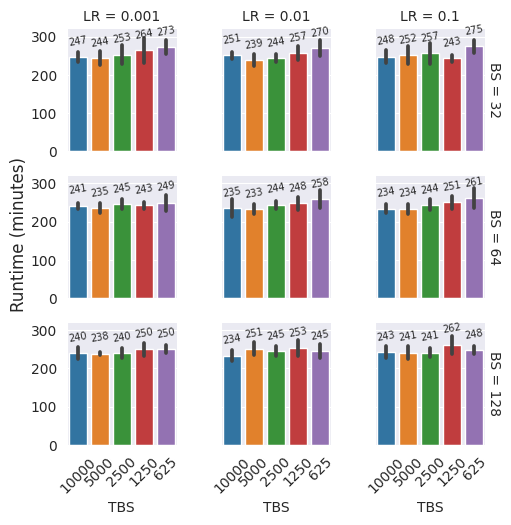

In [10]:
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

usecols = ["target_batch_size", "batch_size_per_step", "optimizer_params.lr", "_runtime"]

data = pd.read_csv(os.path.abspath('') + f"/summary-{filename}", usecols=usecols)
data = data.sort_values(["target_batch_size"], ascending=[False]).reset_index(drop=True)

g = sns.FacetGrid(data, row="batch_size_per_step", col="optimizer_params.lr", margin_titles=True, height=1.8, gridspec_kws={"wspace":0.4}, aspect=1)
g.set_xticklabels(rotation=45)
g2 = g.map_dataframe(
    sns.barplot,
    x="target_batch_size",
    y="_runtime",
    errorbar="sd",
    dodge=False,
    order=data["target_batch_size"].unique(),
    palette="tab10"
)
for axlist in g2.axes:
    for ax in axlist:
        for i in ax.containers:
            ax.bar_label(i, fmt="%.0f", fontsize=7, rotation=10, padding=7)
g.set_titles(row_template="BS = {row_name}", col_template="LR = {col_name}")
g.set_ylabels("")
g.figure.supylabel("Runtime (minutes)")
g.set(ylim=(0, 320))
g.set_axis_labels("TBS")

g.figure.savefig(f"../../figures/06_{filename.replace('.csv', '.pdf')}", bbox_inches="tight")

In [35]:
import os
import json
import pandas as pd
import ast
from viz import load_baseline_data, find_baseline, print_increase_info

data = pd.read_csv(os.path.abspath('') + f"/summary-{filename}")
baseline_data = load_baseline_data()

# temporary
data = data[data["gradient_accumulation_steps"] == 1]
to_keep = ["max_steps", "batch_size_per_step", "optimizer_params.lr", "target_batch_size", "gradient_accumulation_steps"]
data = data.groupby(to_keep)["_runtime", "train/loss"].describe().reset_index()
data = data.sort_values(
    to_keep,
    ascending=[False, True, True, False, True]
)
latex_output = []

last_batch_size = 0
for _, row in data.iterrows():
    max_steps = int(row['max_steps'])
    batch_size_per_step = int(row['batch_size_per_step'])
    lr = row['optimizer_params.lr'][0]
    target_batch_size = int(row['target_batch_size'])
    gas = int(row['gradient_accumulation_steps'])

    # grabbing max, as this is the actual end of the run
    runtime_max = round(row["_runtime"]['max'], 2)
    loss_min = round(row["train/loss"]["min"], 4)

    if batch_size_per_step != last_batch_size:
        latex_output.append(f"\\multicolumn{{7}}{{|c|}}{{Batch size {batch_size_per_step}}} \\\\")
        latex_output.append("\\hline")
        last_batch_size = batch_size_per_step

    baseline_run = find_baseline(baseline_data, batch_size_per_step, lr, gas)
    runtime_string = print_increase_info(runtime_max, baseline_run["_runtime"]["mean"])
    loss_string = print_increase_info(loss_min, baseline_run["train/loss"]["min"])

    latex_output.append(f"{max_steps} & {batch_size_per_step} & {lr} & {target_batch_size} & {gas} & {runtime_string} & {loss_string} \\\\")
    latex_output.append("\\hline")

latex_output = "\n".join(latex_output)
with open(f"../../figures/06_summary-{filename.replace('.csv', '.tex')}", "w+") as f:
    f.write(latex_output)


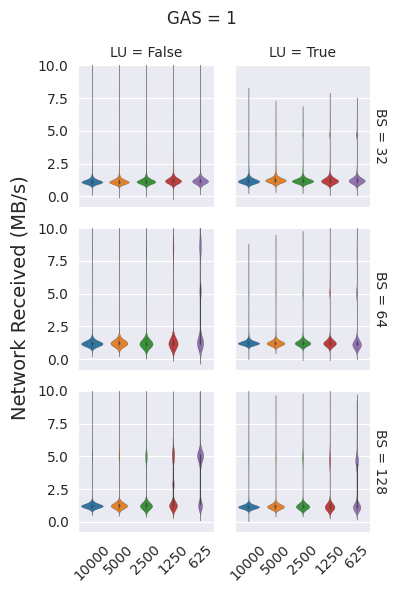

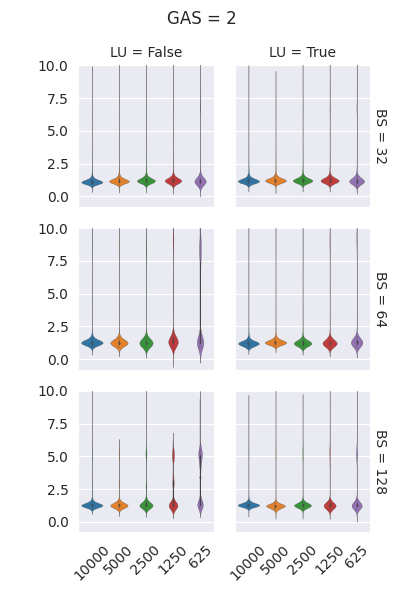

In [118]:
from viz import viz_column_all
viz_column_all("06", filename, "bandwidth/net_recv_sys_bandwidth_mbs", ylabel="Network Received (MB/s)", ylim=(-0.8, 10))

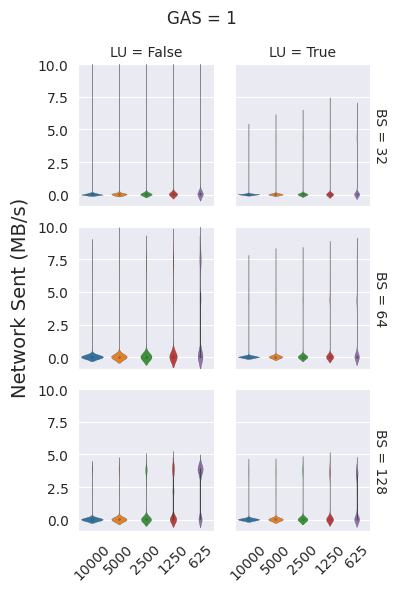

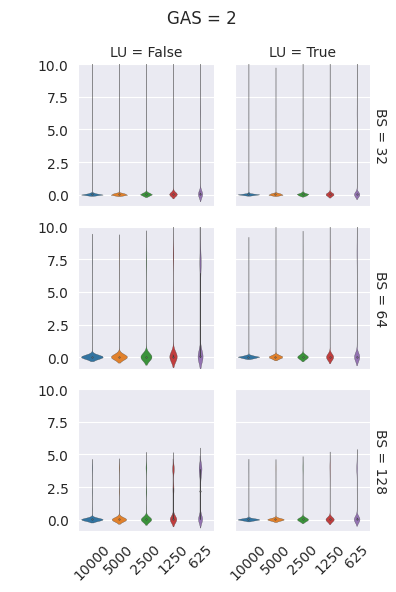

In [128]:
from viz import viz_column_all
viz_column_all("06", filename, "bandwidth/net_sent_sys_bandwidth_mbs", ylabel="Network Sent (MB/s)", ylim=(-0.9, 10))

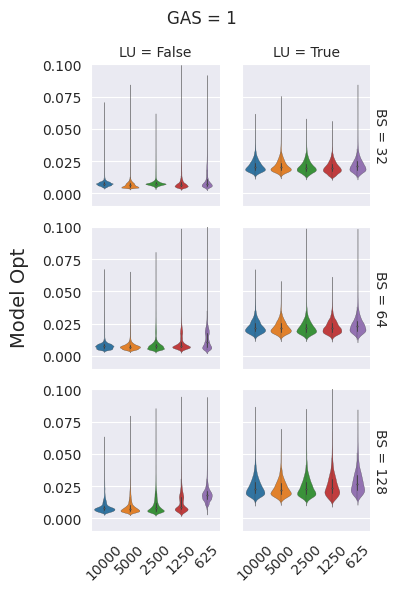

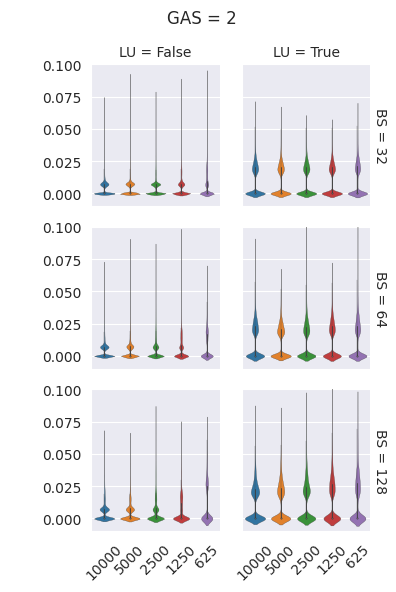

In [125]:
from viz import viz_column_all
viz_column_all("06", filename, "train/model_opt_s", ylabel="Model Opt", ylim=(-0.01, 0.1))

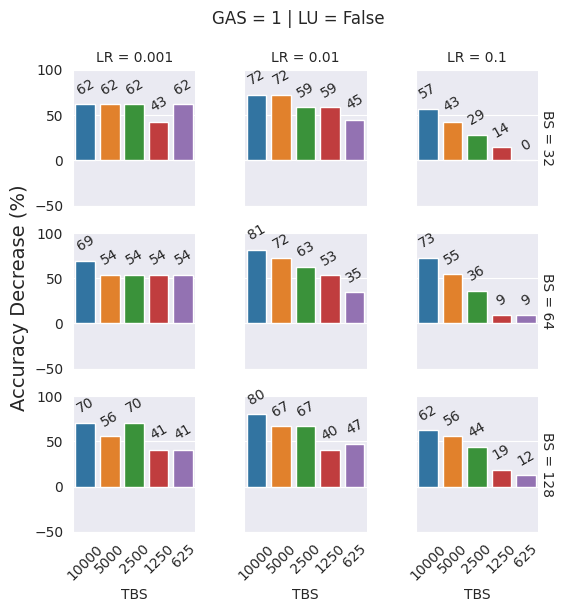

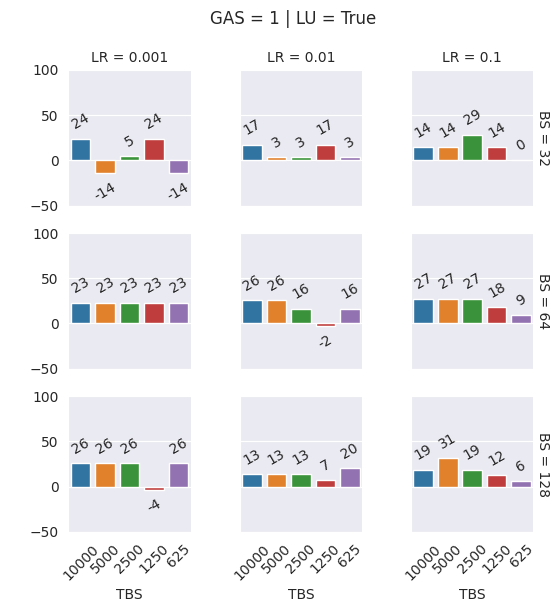

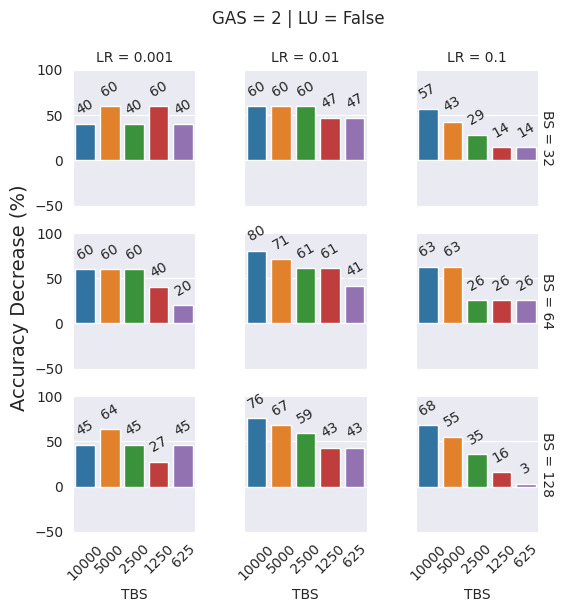

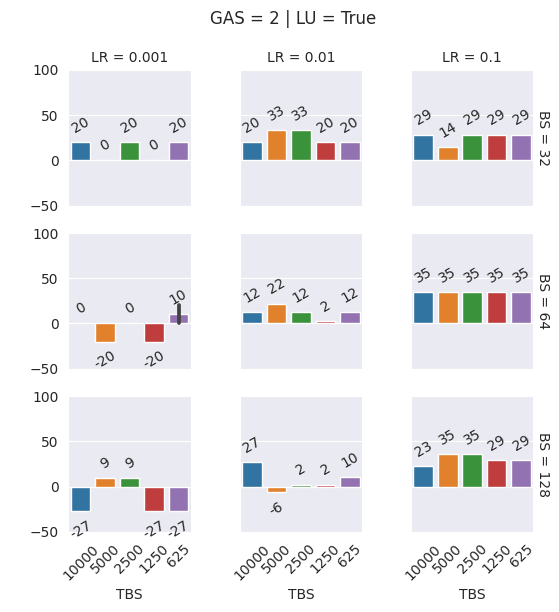

In [3]:
import pandas as pd
from viz import load_baseline_data, find_baseline, print_increase_info, calc_increase_info

group_by = ["target_batch_size", "batch_size_per_step", "optimizer_params.lr", "gradient_accumulation_steps", "use_local_updates", "run_name"]
ascending = [False, False, True, True, True, False]
describe_cols = ["train/accuracy"]

summary_data = pd.read_csv(os.path.abspath('') + f"/summary-{filename}", usecols=[*group_by, *describe_cols])
baseline_data = load_baseline_data()

summary_data = summary_data.groupby(by=group_by)[describe_cols].describe().reset_index()

def calculate_accuracy_decrease(row):
    baseline_run = find_baseline(baseline_data, row["batch_size_per_step"].item(), row["optimizer_params.lr"].item(), row["gradient_accumulation_steps"].item())
    if baseline_run is not None:
        increase_value, increase_sign, increase_color = calc_increase_info(row["train/accuracy"]["max"], baseline_run["train/accuracy"]["mean"], sign=-1)
        return increase_value * (-1 if increase_sign == "-" else 1)
    return 0

summary_data["accuracy_decrease"] = summary_data.apply(calculate_accuracy_decrease, axis=1)
summary_data = summary_data.sort_values(group_by, ascending=ascending).reset_index(drop=True)

figures = []

for gas in [1, 2]:
    data_gas = summary_data[summary_data["gradient_accumulation_steps"] == gas]
    for use_local_updates in [False, True]:
        data_gas_ulu = data_gas[data_gas["use_local_updates"] == use_local_updates]

        g1 = sns.FacetGrid(data_gas_ulu, row="batch_size_per_step", col="optimizer_params.lr", height=2, margin_titles=True, gridspec_kws={"wspace": 0.4, "hspace": 0.2})
        g1.figure.suptitle(f"GAS = {gas} | LU = {use_local_updates}")
        g1.set_xticklabels(rotation=45)
        g2 = g1.map_dataframe(
            sns.barplot,
            x="target_batch_size",
            y="accuracy_decrease",
            dodge=False,
            order=data_gas_ulu["target_batch_size"].unique(),
            palette="tab10"
        )
        for axlist in g2.axes:
            for ax in axlist:
                for i in ax.containers:
                    ax.bar_label(i, fmt="%.0f", rotation=30, padding=5)

        g1.set_xlabels("TBS")
        g1.set_titles(row_template="BS = {row_name}", col_template="LR = {col_name}")
        g1.set_ylabels(" ")
        if not use_local_updates:
            g1.figure.supylabel("Accuracy Decrease (%)", fontsize=14)
        g1.set(ylim=(-50, 100))
        figure_filename = f"../../figures/06_barplot-loss_gas-{gas}_lu-{use_local_updates}_{filename.replace('.csv', '.pdf')}"
        figures.append((g1.figure, figure_filename))
        plt.show()

for figure, figure_filename in figures:
    figure.savefig(figure_filename, bbox_inches='tight')

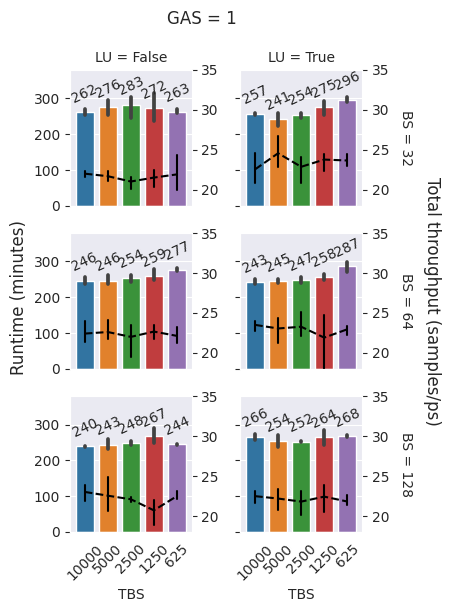

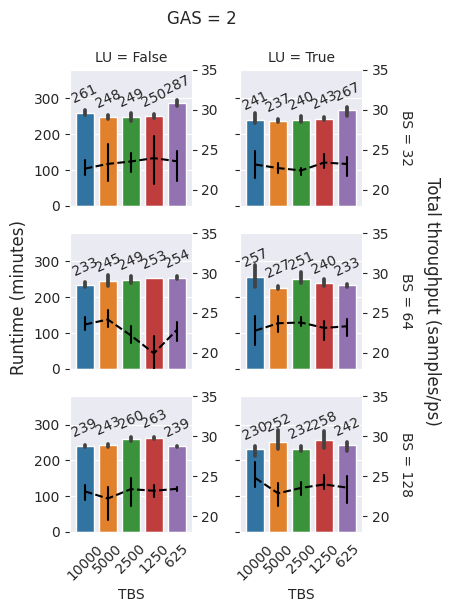

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from viz import load_baseline_data

group_by = ["use_local_updates", "target_batch_size", "batch_size_per_step", "optimizer_params.lr", "gradient_accumulation_steps", "run_name"]
ascending = [True, False, False, True, True, False]
describe_cols = ["_runtime", "train/samples_ps"]

summary_data = pd.read_csv(os.path.abspath('') + f"/summary-{filename}", usecols=[*group_by, *describe_cols])

summary_data = summary_data.groupby(by=group_by).agg({
    "_runtime": "max",
    "train/samples_ps": "sum",
}).reset_index()

summary_data = summary_data.sort_values(group_by, ascending=ascending).reset_index(drop=True)
# convert to string
summary_data["target_batch_size"] = summary_data["target_batch_size"].astype(str)

# set as Categorical and Categories as strings
summary_data["target_batch_size"] = pd.Categorical(summary_data["target_batch_size"], categories=map(str, summary_data["target_batch_size"].unique()), ordered=True)

figures = []

def twinx_lineplot(x, y, data, color, **kwargs):
    ax = plt.gca()
    ax2 = plt.twinx()
    ax2.grid(False)
    sns.lineplot(data, x=x, y=y, **kwargs, ax=ax2, color="black", linestyle="--", err_style="bars")
    ax2.set_ylabel("")
    ax2.set_ylim(bottom=18, top=35)

for gas in [1, 2]:
    data_gas = summary_data[summary_data["gradient_accumulation_steps"] == gas]

    g1 = sns.FacetGrid(data_gas, row="batch_size_per_step", col="use_local_updates", height=2, margin_titles=True, gridspec_kws={"wspace": 0.4})
    g1.figure.suptitle(f"GAS = {gas}")
    g1.set_xticklabels(rotation=45)

    g2 = g1.map(
        sns.barplot,
        "target_batch_size",
        "_runtime",
        dodge=False,
        palette="tab10",
    )

    g3 = g1.map_dataframe(
        twinx_lineplot,
        x="target_batch_size",
        y="train/samples_ps",
    )

    for axlist in g2.axes:
        for ax in axlist:
            for i in ax.containers:
                ax.set_ylim(top=380)
                ax.bar_label(i, fmt="%.0f", rotation=25, padding=5)

    g1.set_titles(row_template="BS = {row_name}", col_template="LU = {col_name}")
    for annotation in g1._margin_titles_texts:
        annotation.set_position((1.3, .5))
    
    g1.axes[1, -1].annotate(
        "Total throughput (samples/ps)",
        xy=(1.5, .5),
        xycoords="axes fraction",
        rotation=270,
        ha="left",
        va="center",
        fontsize=12,
    )

    g1.set_xlabels("TBS")
    g1.set_ylabels("")
    g3.set_ylabels("")
    g1.figure.subplots_adjust(left=0.17)
    g1.figure.supylabel("Runtime (minutes)", fontsize=12)
    figure_filename = f"../../figures/06_barplot-runtime_gas-{gas}_{filename.replace('.csv', '.pdf')}"
    figures.append((g1.figure, figure_filename))
    plt.show()

for figure, figure_filename in figures:
    figure.savefig(figure_filename, bbox_inches='tight')

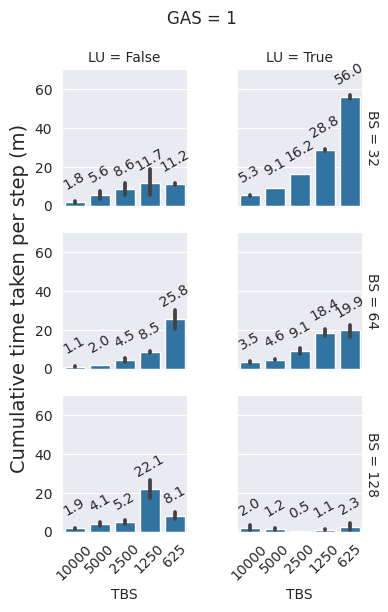

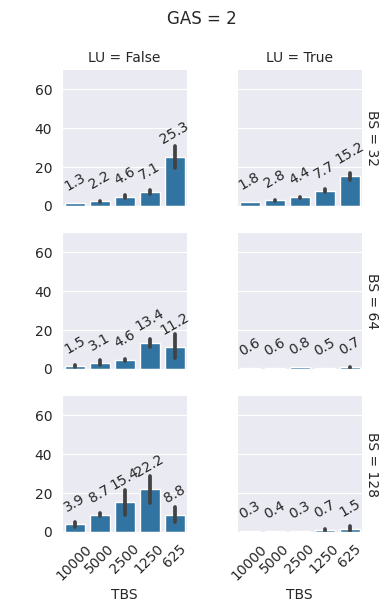

In [8]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt

group_by_1 = ["target_batch_size", "batch_size_per_step", "gradient_accumulation_steps", "use_local_updates", "optimizer_params.lr", "name"]
ascending = [False, False, True, True, False, False]

data_cols = ["train/data_load_s", "train/model_forward_s", "train/model_backward_only_s", "train/model_opt_s"]

summary_data = pd.read_csv(os.path.abspath('') + f"/{filename}", usecols=[*group_by_1, *data_cols])

# summary_data = summary_data.groupby(by=group_by_1)[data_cols].mean().reset_index()
summary_data = summary_data.groupby(by=group_by_1)[data_cols].sum().reset_index()

summary_data = summary_data.sort_values(group_by_1, ascending=ascending).reset_index(drop=True)

def stacked_bar(x, color, data, **kwargs):
    palette = itertools.cycle(sns.color_palette("tab10"))
    opt_cumulated_column = data["train/model_opt_s"] / 60
    opt_labels = "opt.step()"

    ax = sns.barplot(data, x=x, y=opt_cumulated_column, label=opt_labels, color=next(palette), **kwargs)
    for i, container in enumerate(ax.containers):
        if i % 4 == 0:
            ax.set_ylim(top=70)
            ax.bar_label(container, fmt="%.1f", rotation=30, padding=7)

for gas in [1, 2]:
    data_gas = summary_data[summary_data["gradient_accumulation_steps"] == gas].reset_index(drop=True)
    g1 = sns.FacetGrid(data_gas, col="use_local_updates", row="batch_size_per_step", height=2, margin_titles=True, gridspec_kws={"wspace": 0.4, "hspace": 0.2})
    g1.figure.suptitle(f"GAS = {gas}")
    g1.set_xticklabels(rotation=45)

    g2 = g1.map_dataframe(
        stacked_bar,
        x="target_batch_size",
        dodge=False,
        order=data_gas["target_batch_size"].unique(),
        linewidth=1,
    )

    g1.set_titles(row_template="BS = {row_name}", col_template="LU = {col_name}")
    g1.set_xlabels("TBS")
    g1.set_ylabels("")
    g1.figure.subplots_adjust(left=0.15)
    if gas == 1:
        g1.figure.supylabel("Cumulative time taken per step (m)", fontsize=14)
    if gas == 2:
        g1.figure.supylabel(" ", fontsize=14)
    g1.tight_layout()
    g1.figure.savefig(f"../../figures/06_barplot-times_gas-{gas}_{filename.replace('.csv', '.pdf')}", bbox_inches='tight')
    plt.show()

